In [1]:
# modules

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.pardir)

from dataset.mnist import load_mnist
# 本書公式 GitHub (https://github.com/oreilly-japan/deep-learning-from-scratch) で提供されてるモジュール．
# カレントディレクトリに dataset をダウンロードして置いておく，
# あるいは普通にリモートリポジトリごと
# $ git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git
# でローカルに git clone しておく．

# from common.math_functions import *

%load_ext rpy2.ipython
# rpy2 で R も使いたい場合↑


In [2]:
# 4,5 章の勉強のときに作ったやつ．後で使うから定義しとく．


def numerical_gradient_batch(f, X):  # 複数の座標の勾配を計算する．
    grad = np.zeros_like(X) 
    for idx, x in enumerate(X):       # X の行をループ． 行番号が idx に入り，行ベクトルが x に入る．
        grad[idx, :] = numerical_gradient(f, x)
    return grad


def plot_grad_2d(f, x_range, y_range, sep, sign=1):
    
    x = np.arange(x_range[0], x_range[1], sep)  # x 軸の刻み
    y = np.arange(y_range[0], y_range[1], sep)  # y 軸の刻み

    X, Y = np.meshgrid(x, y)      # 全格子点の x 座標が X に， y 座標が Y に． [参考](https://deepage.net/features/numpy-meshgrid.html)
    # print(X, Y)                             # X , Y の [i , j] が　i 行 j　列の格子に対応
    # print(X.shape, Y.shape)

    X = X.flatten()                       # vec してベクトルに変換
    Y = Y.flatten()
    # print(X, Y)      # X,Yの対について勾配を求めて可視化すれば良い．
    # print(X.shape, Y.shape)
    
    grad = numerical_gradient_batch(f, np.array([X, Y]).T)
    # np.array([X, Y]) を .T で転置し， 行が case　で列が変数の形にし， 勾配計算関数に渡す

    plt.figure()  # 初期化的な．なくても良いかも．

    plt.quiver(X, Y, sign * grad[:, 0], sign * grad[:, 1],  angles="xy",color="#666666")
    # ベクトル場を plot する plt.quiver．
    # plt.quiver(x座標値, y座標値, ベクトルのx方向の値, ベクトルのy方向の値)
    # angles="xy" は x-y 平面に描画してねという指定．

    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid(linestyle=":")  # メモリの格子線を引く．
    plt.draw()  # 描画の実行的な．なくても良いかも．
    # plt.show()  # 表示的な．なくても良いかも．
    

def numerical_gradient(f, x):
    """数値的に勾配ベクトルを求める
    
    これまでに作った numerical_gradient() はベクトルを引数に取る関数だけが対象だった．
    ここでは，行列(重み係数W)を引数に取る関数(損失関数)の勾配も求められるようにする．
    Args:
      f: 勾配を求めたい関数．
      x: 勾配を求めたい地点 
    
    """
    h = 1e-4                            # 丸め誤差に注意し小さすぎない値
    grad = np.zeros_like(x)  #  勾配は変数と同じ形状．入力が行列な関数には勾配行列を求める．
    
    it = np.nditer(x, flags=['multi_index'])  # 勾配を求めたい座標値 x をイテレータ化．
    
    while not it.finished:           # イテレータなら ndim によらず1 重ループで書ける．
        
        idx = it.multi_index        # 元の行列 x の何行何列か
        tmp_val = x[idx]            # 変数 x_{idx} の元の値を逃しておく
        
        x[idx] = tmp_val + h     # 変数 x_{idx} を元の値からちょっとプラスにずらして，
        fxh1 = f(x)                     # その位置での関数値を取得．
        
        x[idx] = tmp_val - h      # 変数 x_{idx} を元の値からちょっとマイナスにずらして ，
        fxh2 = f(x)                     # その位置での関数値を取得．
        
        grad[idx] = (fxh1 - fxh2) / (2*h)    # 中心差分で偏微分係数を近似算出
        
        x[idx] = tmp_val            # 変数 x_{idx} の値を元に戻す．
        
        it.iternext()                    # イテレータを１つ進めて次の変数を見るようにする． 
        
    return grad

# 6章 学習に関するテクニック

この章でやるのは，学習の計算効率と汎化性能を上げるために選定する必要のある，

- 最適化手法 ( 更新アルゴリズム, optimizer )：6.1 節
- パラメータの初期値：6.2節
- 様々なメリットを持つ Batch Normalization：6.3 節
- over fitting を抑える正則化としての Weight decay と Dropout：6.4 節
- ハイパーパラメータチューニング ( Optuna 的な )：6.5 節

などなど．奥が深いだろうから MLP とか PRML とか Goodfellow 本も参照．


# 6.1. パラメータの更新

## 6.1.2. SGD

In [3]:
# SGD をクラスで実装


class SGD:
    """ (Stochastic) Gradient Descent optimizer
    
    クラスじゃなくて関数で実装しても良いと思うが，なんかアドバンテージあるんだろう．
    複数の optimizer のクラスに同じようなメソッドを持たせておけば，統一的に扱える，とかかな．
    → テキストの次ページに書いてあったので↓の md セルで引用した．
    
    Attributes:
      lr: learning rate
    
    """
    
    def __init__(self, lr=0.01):
        """ initialize
        
        Args:
          lr: learning rate.
        
        """
        self.lr = lr
        
    def update(self, params, grads):
        """ update params by Gradient Descent
        
        Args:
          params: パラメータ値の numpy.array を持った dictionary
          grads: 勾配の numpy.array を持った dictionary で， key は params に対応してる．
        
        Note:
          返却値は無し．その代わり，引数で渡したアドレスのとこのオブジェクトを上書きしてる．
        
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key]
    

In [4]:
# ↑の SGD クラスの簡単な動作確認

optimizer = SGD(lr=0.1)
params = {
    "para1": np.random.normal(size=(2, 4)), 
    "para2": np.random.normal(size=(4))
}
grads = {
    "para1": np.random.normal(size=(2, 4)), 
    "para2": np.random.normal(size=(4))    
}
print(params["para1"])
print(params["para2"], "\n")
print(grads["para1"])
print(grads["para2"], "\n")
optimizer.update(params, grads)
print(params["para1"])
print(params["para2"])

# うんアルゴリズム通り計算できてる．

[[-0.96182778 -0.69373369  0.63408984  0.64140927]
 [-0.32881878 -0.58642892  0.24816442  1.25204015]]
[-1.0168809   0.49079209 -0.10776371 -0.29017658] 

[[-1.02842401 -0.91803757  0.96016881 -0.83467417]
 [ 1.42559977 -0.32767292 -0.68969202 -0.08309527]]
[ 1.47664636  1.35683203 -1.00667545 -0.17728249] 

[[-0.85898538 -0.60192993  0.53807296  0.72487668]
 [-0.47137875 -0.55366163  0.31713362  1.26034967]]
[-1.16454553  0.35510888 -0.00709616 -0.27244833]


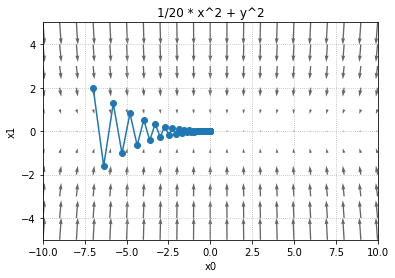

In [5]:
# 前に作った関数を使って図 6-3 的な描画をして， SGD クラスの動作確認

def func_tmp(x):
    return 1/20 * x[0]**2 + x[1]**2

plot_grad_2d(func_tmp, [-10, 10.01], [-5, 5.01], 1.0, sign=-1)
# numerical_gradient_batch(function_2, np.array([[3.0, 4.0], [2.0, 3.0]]))

optimizer = SGD(lr=0.9)
params = {"k": np.array([-7.0, 2.0])}
iters = 100
lis = np.zeros(shape=(iters, 2))
for i in range(iters):
    grads = {"k": numerical_gradient(func_tmp, params["k"])}
    lis[i, 0] = params["k"][0]
    lis[i, 1] = params["k"][1]    
    optimizer.update(params, grads)

plt.plot(lis[:, 0], lis[:, 1], marker="o")
plt.title("1/20 * x^2 + y^2")
plt.show()

> [p168] このように、最適化を行うクラスを分離して実装することで、機能のモジュール化が容易になります。たとえば、この後すぐに Momentum という別の最適化手法を実装しますが、その Momentum も同じく `update(params, grads)` という共通のメ ソッドを持つように実装します。そうすれば、`optimizer = SGD()` という一文を、 `optimizer = Momentum()` に変更するだけでSGDをMomentumに切り替えるこ とができます。

ここが，SGD とかの optimizer を関数でなくクラスで実装するメリット．optimizer は必ず共通して「パラメータ更新」という操作をするが，他に各 optimizer 固有の操作が存在する時もあるだろう．こういうケースの時に，関数(イメージ的には単一のメソッド)で各 optimizer を実装するのは辛いし筋が悪い．必ず共通して .update() と言うメソッドを持つ (それ以外に各 optimizer 固有のメソッドを持ってていい) ようなクラスで実装する方が筋が良い．

また，あとで Momentum とか AdaGrad の実装の時に思ったが「過去の物体速度，勾配情報」みたいな「状態」を attributes に保持できるっていうのもクラスでの実装のメリット．

## 6.1.3. SGD の欠点

> [p169, 170] なお、SGD の非効率な探索経路の根本的な原因は、勾配の方向が本来の最小値ではない方向を指していることに起因します。この SGD の欠点を改善するため、続いて、SGD に代わる手法として、Momentum、 AdaGrad、Adam という 3 つ手法を紹介します。

この原因の説明は納得．図 6-1, 6-2, 6-3 もわかりやすい． Momentum, AdaGrad, Adam がどうやってこの原因を解決しているのかに注目していく．

## 6.1.4. Momentum

前までの速度を持っておいてるので「急に進む向きを変えたりしない，SGDみたいにジグザグに動かない」と言う感じか．

物理的にやってることはかなりシンプルで，１秒ごとに速度を「空気抵抗の力+勾配を降る方向の力を１秒間加え続けた時の速度」に変えて，１秒だけ進めている．「前の更新方向を記録しておいて，そこからあんまり急激に向きが変わらない」というのがポイント．

更新式のパラメータ $W$ を $x$ に代えて変形して，

$$
\begin{aligned}
v &\leftarrow \alpha v - \eta \frac{\partial L}{\partial x} \\
&= v + \left( - (1 - \alpha) v - \eta \frac{\partial L}{\partial x} \right) \\
x &\leftarrow x + v
\end{aligned}
$$

とすると物理的な解釈がしやすい．速度がベクトルであることに注意して，簡単なニュートン力学で考えると，

1. 物体が動いていない ( 速度 $v = 0$ ) シーンから始める． 
2. 空気抵抗の力と傾斜をくだる方向の力 (重力の傾斜方向の分力)の合力 $ - (1 - \alpha) v - \eta \frac{\partial L}{\partial x}$ を物体に１秒間かけ続けた時の速度 $v$ に更新する．( 質量は $m=1$ だと考える．つまり $F = ma = a$ と想定する．)
3. その速度で物体を等速直線運動させる．
4. 指定された回数だけ (もしくは収束つまり速度0になるまで) 2 と 3 を繰り返す．

と言う感じで解釈できる．

一定の力を加え続けて等加速度運動 (速度が連続的) をさせるわけではなく，離散的に速度を変化させ若干ジグザグな動きになるので,「球体をボウルに転がす」みたいなリアルな滑らかな物理運動にはならない．言い換えると，現実では物質が動くと刻一刻と受ける力 (勾配,空気抵抗) や速度も変化するが，そこまでは考慮してない．ただ，learning rate $\eta$ を小さめにしてステップ幅 (速度) を小さくすれば，ほぼリアルな動きになりそう．図 6-5 見るとそう思う．

DNN への Momentum の適用を論じた代表的な論文として，Sutskever et al. (2013) の [On the importance of initialization and momentum in deep learning](http://proceedings.mlr.press/v28/sutskever13.pdf) があって，そこでは

> The momentum method (Polyak, 1964), which we refer
to as classical momentum (CM), is a technique for accelerating gradient descent that accumulates a velocity vector in directions of persistent reduction in the objective across iterations. Given an objective function
$f(\theta)$ to be minimized, classical momentum is given by:
$$
v_{t+1} = \mu v_t - \varepsilon \Delta f(\theta_t) \\
\theta_{t+1} = \theta_t + v_{t+1}
$$
where $\varepsilon > 0$ is the learning rate, $\mu \in [0, 1]$ is the momentum coecient, and $\Delta f(\theta_t)$ is the gradient at $\theta_t$.

という風にアルゴリズムを定義してる．ここで $\mu \in [0, 1]$ は結構ポイントだと思って，なんでかというと，先ほど式変形して得た空気抵抗の係数が $(1-\alpha) > 0$ という感じで正の値になってくれるから．これでちゃんと「進行方向とは逆方向に空気抵抗の力がかかる」ことになってくれる．まあ結局，パラメータ $\alpha$ は「空気抵抗 (係数) の小ささ，勢いがどれくらい殺されないか」を表すことになる．

In [6]:
# Momentum をクラスで実装


class Momentum:
    """ Momentum optimizer
    
    Momentum を実装したクラス．
    イメージはボウルを転がる球体の運動．
    
    Attributes:
      lr: learning rate
      momentum: (1-momentum) が空気抵抗係数． 勢いがどのくらい殺されないか．
      v: 1秒(1更新)ごとに変化していく速度ベクトルの dict．
        key は .update() で初めて渡された params に対応するようになる．
        過去の運動の情報が速度の形で保存されていて，それが使われるのが Momentum の肝．
        こういう状態を保持できるのは，クラスで実装したメリットだなあ．
    
    """
    
    def __init__(self, lr=0.01, momentum=0.9):
        """ initialize
        
        Args:
          Attributes の docstring 参照．
        
        """
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        """ update params by momentum method
        
        Args:
          params: パラメータ値の numpy.array を持った dictionary
          grads: 勾配の numpy.array を持った dictionary で， key は params に対応してる．
        
        """
        
        if self.v is None:  # 初めての更新の際は速度 v を 0 で初期化
            self.v = {}
            for key in params.keys():
                self.v[key] = np.zeros_like(params[key])
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


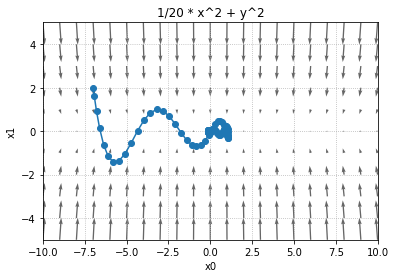

In [7]:
# 前に作った関数を使って図 6-5 的な描画をして， momentum クラスの動作確認

plot_grad_2d(func_tmp, [-10, 10.01], [-5, 5.01], 1.0, sign=-1)
# numerical_gradient_batch(function_2, np.array([[3.0, 4.0], [2.0, 3.0]]))

optimizer = Momentum(lr=0.1, momentum=0.9)
params = {"k": np.array([-7.0, 2.0])}
iters = 100
lis = np.zeros(shape=(iters, 2))
for i in range(iters):
    grads = {"k": numerical_gradient(func_tmp, params["k"])}
    lis[i, 0] = params["k"][0]
    lis[i, 1] = params["k"][1]    
    optimizer.update(params, grads)

plt.plot(lis[:, 0], lis[:, 1], marker="o")
plt.title("1/20 * x^2 + y^2")
plt.show()

## 6.1.5. AdaGrad

> [p172, 173] 学習係数を徐々に下げていくというアイデアは、パラメータ「全体」の学習係数の 値を一括して下げることに相当します。これをさらに発展させたのが AdaGrad [6] です。AdaGrad は、「一つひとつ」のパラメータに対して、“オーダーメイド”の値をこしらえます。AdaGrad は、パラメータの要素ごとに適応的に学習係数を調整しながら学習を行う手法です(AdaGrad の Ada は「適応的」を意味する Adaptive に由来します)。

ここがポイント．大量にあるパラメータそれぞれに対して learning rate を別々に (適応的に) 定める．

行列は大文字で表したいし，アダマール積(要素ごとの積) を $\odot$ で表すのと同じように，アダマール除算は $\oslash$ で表し，要素単位の演算(べき乗) は $\circ$ をつける[そう](https://omedstu.jimdofree.com/2018/04/23/%E3%82%A2%E3%83%80%E3%83%9E%E3%83%BC%E3%83%AB%E6%BC%94%E7%AE%97%E5%AD%90-hadamard-operation/)なので， AdaGrad 更新式 (6.5), (6.6) は

$$
\begin{aligned}
H &\leftarrow
H+\frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}\\
W &\leftarrow
W - \eta \frac{\partial L}{\partial W} \oslash H^{\circ \frac{1}{2}} \\
&= W - \left( \eta H^{\circ -\frac{1}{2}} \right) \odot \frac{\partial L}{\partial W}
\end{aligned}
$$

と表しておこう．こう変形すると「適応的な学習率」てのがわかりやすい．


> [p173] この $h$ は、式 (6.5) で示されるように、これまで経験した勾配の値を 2 乗和として
保持します(式 (6.5) の $\odot$ は行列の要素ごとの掛け算を意味します)。そして、パラ
メータの更新の際に、$\frac{1}{h}$ を乗算することで、学習のスケールを調整します。これは、パラメータの要素の中でよく動いた(大きく更新された)要素は、学習係数が小さく なることを意味します。つまり、よく動いたパラメータの学習係数は次第に小さくな るという学習係数の減衰を、パラメータの要素ごとに行うことができるのです。AdaGrad は、過去の勾配を 2 乗和としてすべて記録します。そのため、学習を進めれば進めるほど、更新度合いは小さくなります。

わかりやすい．確かにこれなら SGD のジグザグ反復運動にペナルティが課される感じになってうまくいきそう．実際，テキストでも

> [p174] 図 6-6 の結果を見ると、最小値に向かって効率的に動いているのが分かります。$y$ 軸方向へは勾配が大きいため、最初は大きく動きますが、その大きな動きに比例して、更新のステップが小さくなるように調整が行われます。そのため、$y$ 軸方向への 更新度合いは弱められていき、ジグザグの動きが軽減されます。

とコメントされているし．

In [8]:
# AdaGrad をクラスで実装


class AdaGrad:
    """ AdaGrad optimizer
    
    Attributes:
      lr: learning rate
      h: 過去の勾配の二乗和
    
    """
    
    def __init__(self, lr=0.01):
        """ initialize
        
        """
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        """ update params by AdaGrad
        
        """
        if self.h is None:
            self.h = {}
            for key in params.keys():
                self.h[key] = np.zeros_like(params[key])
                
        for key in params.keys():
            self.h[key] += grads[key]**2
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)  # 0除算対策

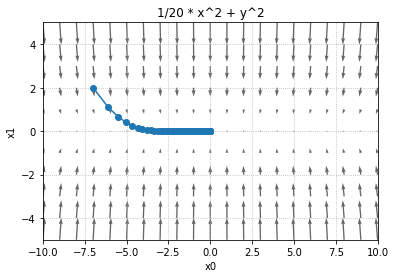

In [9]:
# 前に作った関数を使って図 6-6 的な描画をして， AdaGrad クラスの動作確認

def func_tmp(x):
    return 1/20 * x[0]**2 + x[1]**2

plot_grad_2d(func_tmp, [-10, 10.01], [-5, 5.01], 1.0, sign=-1)
# numerical_gradient_batch(function_2, np.array([[3.0, 4.0], [2.0, 3.0]]))

optimizer = AdaGrad(lr=0.9)
params = {"k": np.array([-7.0, 2.0])}
iters = 100
lis = np.zeros(shape=(iters, 2))
for i in range(iters):
    grads = {"k": numerical_gradient(func_tmp, params["k"])}
    lis[i, 0] = params["k"][0]
    lis[i, 1] = params["k"][1]    
    optimizer.update(params, grads)

plt.plot(lis[:, 0], lis[:, 1], marker="o")
plt.title("1/20 * x^2 + y^2")
plt.show()

今週

----

----

来週

> [p173] AdaGrad は、過去の勾配を 2 乗和としてすべて記録します。そのため、学習を進めれば進めるほど、更新度合いは小さくなります。そのため、学習 を進めれば進めるほど、更新度合いは小さくなります。実際のところ、無限に 学習を行ったとすると、更新量は 0 になり、まったく更新されません。この問 題を改善した手法として、RMSProp [7] という方法があります。RMSProp という手法は、過去のすべての勾配を均一に加算していくのではなく、過去の 勾配を徐々に忘れて、新しい勾配の情報が大きく反映されるように加算します。 専門的には「指数移動平均」と言って、指数関数的に過去の勾配のスケールを 減少させます。

なるほど．

[Goodfellow](http://www.deeplearningbook.org/contents/optimization.html) に AdaGrad と RMSProp のアルゴリズムが並んで載っていたので，引用↓

![goodfellow](https://user-images.githubusercontent.com/55879719/82724693-c5b27300-9d12-11ea-9224-846dfb3ff76d.png)

違っているのは `Accumulate squared gradient` のところで，

- AdaGrad：過去全ての勾配の二乗和
- RMSProp：勾配の指数移動平均（平滑化係数 $1-\rho$） 

となっている．指数移動平均については [wiki](https://ja.wikipedia.org/wiki/%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87#%E6%8C%87%E6%95%B0%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87) を参照で， RMSProp の $\rho$ は「過去の勾配をどのくらい重視して切り捨てないか」という意味になる．

## 6.1.6. Adam

参考リスト↓

- [Adam原論文](https://arxiv.org/pdf/1412.6980.pdf)
- [Goodfellow の optimizer の章](http://www.deeplearningbook.org/contents/optimization.html)：8.5.3節
- [1](https://www.slideshare.net/MotokawaTetsuya/optimizer-93979393)：スライド13にAdamのアイディア．
- [2](https://www.slideshare.net/nishio/ss-66840545)：スライド25にAdamのアイディア．
- [An overview of gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/index.html#adam)：理論についてある程度しっかりかつわかりやすく書かれている．Adagrad + Momentum と言える理由とかも．バイス補正の話も少し．
- [原論文を読んでるブログ](https://qiita.com/exp/items/99145796a87cc6cd47e1)：理論がわかりやすい．確率的目的関数っての導入し，1次2次モーメントのバイアス補正の話へ．

Momentum は $\frac{\partial L}{\partial W}$ を溜め込みながら更新に使って， AdaGrad や RMSProp は $\frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}$ を溜め込みながら更新に使った．

勾配を確率変数と見て期待値を取って考えると，前者は「勾配の１次モーメント」で後者は「勾配の2次モーメント」と見做せる．

Adam は「 ( RMSProp と同様に指数移動平均で ) **Ada**ptive に 1次,2次 **M**oment を推定 (+ バイアス補正) して更新する」というコンセプトのアルゴリズム．
[Goodfellow](http://www.deeplearningbook.org/contents/optimization.html) では

![Goodfellow](https://user-images.githubusercontent.com/55879719/82725589-e54c9a00-9d18-11ea-93c1-693e17a7d50d.png)

と定式化されている． ちなみに原論文の [Kingma and Ba (2015)](https://arxiv.org/pdf/1412.6980.pdf) では，

![Algorithm of Adam](https://user-images.githubusercontent.com/55879719/82725754-25604c80-9d1a-11ea-83f9-d3883dfe90da.png)

と定式化されている．

ここで推奨されているハイパラ値については，原論文のABSTRACT のところで

> The hyper-parameters have intuitive interpretations and typically require little tuning. 

と言及していて， Goodfellow でも

> Adam is generally regarded as being fairly robust to the choiceof hyperparameters, though the learning rate sometimes needs to be changed fromthe suggested default.

と言われていて，本当なら相当なメリット．

バイアス補正については，原著論文 [Kingma and Ba (2015)](https://arxiv.org/pdf/1412.6980.pdf) では

> However, these moving averages are initialized as (vectors of) $0$’s, leading to moment estimates that are biased towards zero, especially during the initial timesteps, and especially when the decay rates are small (i.e. the $\beta$s are close to $1$). The good news is that this initialization bias can be easily counteracted, resulting in bias corrected estimates $\hat{m}_t$ and $\hat{v}_t$. See section 3 for more details.

と説明していて，ざっくり言うと1,2次モーメントの初期値を $0$ にせっていしていることで推定値も $0$ の方に寄ってしまう，というバイアスを補正している．

が，まだ理解できてなくて，原著論文 [Kingma and Ba (2015)](https://arxiv.org/pdf/1412.6980.pdf) section 3 をしっかり読んで「勾配の系列 $g_1, g_2, \ldots, g_T$ を定常仮定 (もはや i.i.d) と見做しているのかどうか，どういう分布のどのパラメータを推定しようとしているか」などの設定を精査して式を追えば分かりそう．

最低限の理解として，勾配の1,2次モーメントの指数移動平均を $\hat{m}_t, \hat{v}_t$ としたときに
$$
\theta_t \leftarrow \theta_{t-1} - \frac{\alpha}{\sqrt{\hat{v}_t} + \varepsilon}{\hat{m}_t}
$$
という式でうまく降下できそうなのは分かる．

In [15]:
# Adam の実装

class Adam:
    """ Adam optimizer
    
    Attributes:
      lr: learning rate
      m : 勾配の 1 次モーメント (勾配そのもの)
      v: 勾配の 2 次モーメント (勾配の2乗)
      t: 繰り返しのステップ index
      beta1: m の指数移動平均による推定において，過去のやつをどのくらい重視して残すか
      beta2: v 〃

    """
    
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        """initialize
        
        """
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.m = None
        self.v = None
        self.t = None
        
    def update(self, params, grads):
        """ update params by Adam
        
        Args:
          params: パラメータ値の numpy.array を持った dictionary
          grads: 勾配の numpy.array を持った dictionary で， key は params に対応してる．
        
        """
        if self.m is None:
            self.m = {}
            self.v = {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
            self.t = 0
        
        self.t += 1
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1-self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1-self.beta2) * grads[key]**2
            m_unbiased = self.m[key] / (1 - self.beta1**self.t)
            v_unbiased = self.v[key] / (1 - self.beta2**self.t)
            params[key] -= self.lr * m_unbiased / (np.sqrt(v_unbiased) + 1e-7)


In [16]:
# 実装の準備実験

dic = {"a": [1,2,3], "b": [1,5,7,3,], "c":"item"}
for key, val in dic.items():
    print(key,val)

a [1, 2, 3]
b [1, 5, 7, 3]
c item


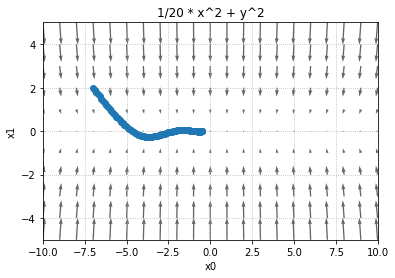

In [22]:
# 前に作った関数を使って図 6-6 的な描画をして， Adam クラスの動作確認

def func_tmp(x):
    return 1/20 * x[0]**2 + x[1]**2

plot_grad_2d(func_tmp, [-10, 10.01], [-5, 5.01], 1.0, sign=-1)
# numerical_gradient_batch(function_2, np.array([[3.0, 4.0], [2.0, 3.0]]))

optimizer = Adam(lr=0.1)
params = {"k": np.array([-7.0, 2.0])}
iters = 100
lis = np.zeros(shape=(iters, 2))
for i in range(iters):
    grads = {"k": numerical_gradient(func_tmp, params["k"])}
    lis[i, 0] = params["k"][0]
    lis[i, 1] = params["k"][1]    
    optimizer.update(params, grads)

plt.plot(lis[:, 0], lis[:, 1], marker="o")
plt.title("1/20 * x^2 + y^2")
plt.show()

## 6.1.8. MNIST データセットによる更新手法の比較

> 一般に SGD よりも他 の 3 つの手法のほうが速く学習でき、時には最終的な認識性能も高くなります。

実際この MNIST の実験では，結果の図 6-9 を見ると，SGD よりも他３つの方が訓練ロスを小さくできている，訓練ロス関数のより深いところにたどり着けている．（汎化性能はどうか分からないけど）

-----

# 6.2. 重みの初期値

## 6.2.1. 重みの初期値を 0 にする？

> [p179] なぜ重みの初期値を 0 にしてはいけない――正確には、重みを均一な値に設定して はいけない――のでしょうか? それは誤差逆伝播法において、すべての重みの値が均一に(同じように)更新されてしまうからです。... これでは、たくさんの重みを持つ意味がなくなってしまいます。この「重みが均一になってしまうこと」を防ぐ――正確には、重みの対称的な構造を崩す――ために、ランダムな初期値が必要な のです。

言われてみると確かに．同じ層のニューロンが全く同じ特徴量になってしまう．

## 6.2.2. 隠れ層のアクティベーション分布

「どのような重みパラメータの初期値が望ましいか？」を考えるにあたって，アクティベーション ( NN における活性化レイヤの出力 ) の分布が参考になる

In [90]:
# 重みの初期化法がアクティベーション分布に与える影響を実験 (するための関数を定義)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    

input_data = np.random.randn(1000, 100)  # n=1000, p=100 の入力データ
node_num = 100  # 隠れ層のノード（ニューロン）数は全て 100 とする．
hidden_layer_size = 5  # 隠れ層が5層
# つまり，この NN の特徴量の次元は，前から
# 100(入力) → 100(中間層1) → 100(中間層2) → 100(中間層3) → 100(中間層4) → 100(中間層5) → 省略(出力層)



def plot_activation_tmp(init_sd, activate_f, x_range=(0,1), ylim=None):

    activations = {}  # ここにアクティベーションの結果を格納する

    x = input_data
    
    for i in range(hidden_layer_size):  # 層をループしてフル forward する．

        # 2層目以降の Affine - Activate 変換では，１つ前の層の出力値 activations を入力とする．
        if i != 0:
            x = activations[i-1]
    
        # 初期値の値をいろいろ変えて実験
        if init_sd == "xavier":
            sd = np.sqrt(1.0 / node_num)
        elif init_sd == "he":
            sd = np.sqrt(2.0 / node_num)
        else:
            sd = init_sd
        w = np.random.randn(node_num, node_num) * sd

        # Affine
        a = np.dot(x, w)  # (1000,100) = (1000, 100) x (100, 100)

        # 活性化関数の種類もいろいろ変えて実験
        act = {"sigmoid": sigmoid, "relu": ReLU, "tanh": tanh}[activate_f]
        z = act(a)

        # record
        activations[i] = z

    # ヒストグラムでアクティベーションの分布を描画
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        # plt.xlim(0.1, 1)
        if ylim is None:
            pass
        else:
            plt.ylim(ylim)
        plt.hist(a.flatten(), 30, range=x_range)
    plt.show()


# 1000 個のデータを 5 隠れ層 (各 100 ニューロン) の NN に流しているので，
# アクティベーションは合計 1000 * 100 * 5 個だけ算出されている．
# それを層ごとに 5 つに分けてヒストグラムで可視化している．
# NN ぽく砕いて解釈すると「獲得された特徴量の値の分布」と見れば良いかも．

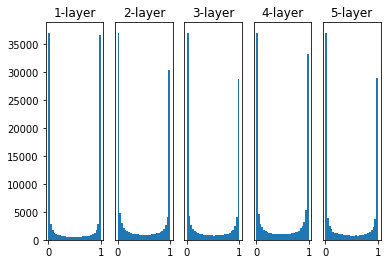

In [91]:
# 重みの初期化法がアクティベーション分布に与える影響を実験

plot_activation_tmp(init_sd=1, activate_f="sigmoid")

> [p180] このコードで注意すべき点は、重みのスケールについてです。今回は標準偏差が 1 の ガウス分布を用いていますが、このスケール(標準偏差)を変えることで、アクティベーションの分布がどのように変化するかを観察することが、この実験の目的です。...
図 6-10 を見ると、各層のアクティベーションは 0 と 1 に偏った分布になっていることが分かります。ここで使用しているシグモイド関数は、S 字カーブの関数です が、シグモイド関数の出力が 0 に近づくにつれて(または 1 に近づくにつれて)、そ の微分の値は 0 に近づきます。そのため、0 と 1 に偏ったデータ分布では、逆伝播 での勾配の値がどんどん小さくなって消えてしまいます。これは勾配消失(gradient vanishing)と呼ばれる問題です。

つまり，重みパラメータ初期値のバラつき (分散) が大きすぎると...

- アフィン変換の出力の絶対値も大きくなりがちで，シグモイドアクティベーションが 0 と 1 に偏る．
- シグモイド関数の 0 と 1 付近は，勾配がほぼ 0．
- chain rule で算出される「重みパラメータについてのロス関数の勾配」もほぼ 0 となる．
- この現象を勾配消失 (gradient vanishing) と呼び，勾配ベースの学習 (SGD とか) が進まなくなって辛い．

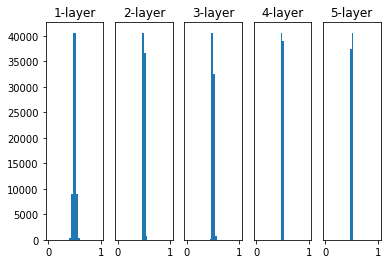

In [92]:
# 重みの初期化法がアクティベーション分布に与える影響を実験

plot_activation_tmp(init_sd=0.01, activate_f="sigmoid")

> 標準偏差を 0.01 としたガウス分布の場合、各層 のアクティベーションの分布は図6-11 のようになります。今度は、0.5 付近に集中する分布になりました。先ほどの例のように 0 と 1 への偏 りはないので、勾配消失の問題は起きません。しかし、アクティベーションに偏りが あるということは、表現力の点で大きな問題があります。なぜなら、複数のニューロ ンがほとんど同じ値を出力するとすれば、複数のニューロンが存在する意味がなく なってしまうからです。たとえば、100 個のニューロンがほぼ同じ値を出力するとす れば、それは 1 個のニューロンでもほぼ同じことを表現することができます。そのため、アクティベーションの偏りは、「表現力の制限」の点で問題になります。

つまり，重みパラメータ初期値のバラ付き (分散) が小さすぎると，最初に述べたように「同じ層のニューロンが同じような特徴量になって，多数のニューロンを使う意味がない」という状況になる．

したがって，重みパラメータ初期値の「ちょうど良い」バラつきが欲しくなる．

[Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) の 「Xavier の初期値」がデファクトスタンダート的な感じで各種 DL フレームワークで使われている．そのルールは

> [p182] Xavier の論文では、各層のアクティベーションを同じ広がりのある分布に
することを目的として、適切な重みのスケールを導きました。その導き出した結論は、前層のノードの個数を $n$ とした場合、$\frac{1}{\sqrt{n}}$ の標準偏差を持つ分布を使うとい
うものです(図 6-12)。

というシンプルなもの．導出はごつい．

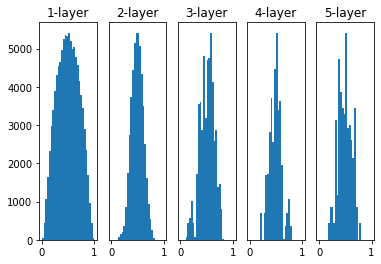

In [93]:
# Xavier の初期化でアクティベーション分布がどうなるか確認

plot_activation_tmp(init_sd="xavier", activate_f="sigmoid")

> [p183] 「Xavier の初期値」を使った結果は図6-13 のようになります。この結果を見ると、 上位の層に行くにつれて、ややいびつな形にはなりますが、これまでよりも広がりを 持った分布になっていることが分かります。各層に流れるデータには適度な広がりが あるので、シグモイド関数の表現力も制限されることなく、効率的に学習が行えるこ とが期待できます。

適度な広がりで，勾配消失の問題も表現力の制限も無さそう

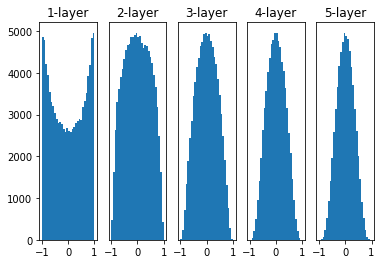

In [94]:
# sigmoid の代わりに tanh を使うとアクティベーション分布がどうなるか確認

plot_activation_tmp(init_sd="xavier", activate_f="tanh", x_range=(-1,+1))

> [p183] 図 6-13 の分布は、上位層の分布の形状がややいびつな形状になりました。こ のややいびつな形状は、sigmoid 関数の代わりに、tanh 関数(双曲線関数) を用いると改善されます。実際、tanh 関数を用いると、キレイな釣鐘型の分布になります。

これを確認できた．（正規分布の密度関数, Affine, 活性化関数を頑張ってヤコビアンとか計算すれば導出できそう．）

## 6.2.3. ReLU の場合の重みの初期値

> [p183] 「Xavier の初期値」は、活性化関数が線形であることを前提に導いた結果です。sigmoid 関数や tanh 関数は左右対称で中央付近が線形関数として見なせるので、
「Xavier の初期値」が適しています。一方、ReLU を用いる場合は、ReLU に特化した初期値を用いることが推奨されています。それは、Kaiming He らが推奨する初期
値――その名も「He の初期値」[10] です。「He の初期値」は、前層のノードの数が
$n$ 個の場合、$\sqrt{\frac{2}{n}}$ を標準偏差とするガウス分布を用います。

なるほど．原著論文は Microsoft Research の方々の [He etal (2015)](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf)．

> [p184] 「Xavier の初期値」が$\sqrt{\frac{1}{n}}$であったことを考えると、ReLU の場合は負の領域が 0 になるため、より広がりを持たせるために倍の係数が必要になると(直感的には)解釈できます。

これは少し納得できて， ReLU だと負の入力に対して出力は常に 0 で，同じような特徴量(アクティベーション) が得られやすいから，重みをよりバラつかせるべき．（あくまで直感的で導出は原著論文を読む）

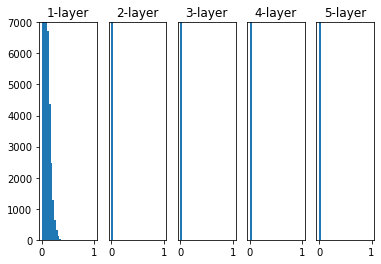

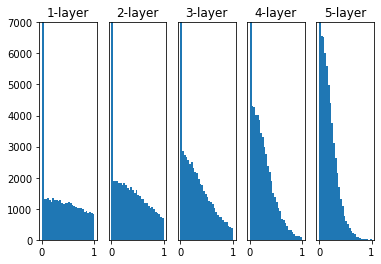

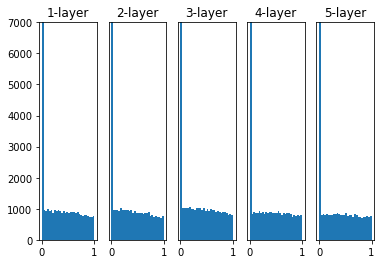

In [97]:
# ReLU を使った時のアクティベーション分布の初期値依存性

plot_activation_tmp(init_sd=0.01, activate_f="relu", ylim=(0, 7000))
plot_activation_tmp(init_sd="xavier", activate_f="relu", ylim=(0, 7000))
plot_activation_tmp(init_sd="he", activate_f="relu", ylim=(0, 7000))

> [p184] 実験の結果を見ると、「std=0.01」の場合、各層のアクティベーションはとても小さな値になります。ニューラルネットワーク上をとても小さなデータが流れるということは、逆伝播の際の重みの勾配も同様に小さくなるということです。これは重 大な問題であり、実際には学習がほとんど進まないでしょう。
続いて「Xavier の初期値」の結果ですが、こちらは、層が深くなるにつれて、偏りが少しずつ大きくなっていきます。実際、層をディープにしていくと、アクティベーションの偏りも大きくなり、学習の際に「勾配消失」が問題になります。一方、「He の初期値」は、各層で分布の広がりが均一になっています。データの広がりが層を深 くしても均一に保たれるので、逆伝播の際も適切な値が流れると期待できます。

すごい．ReLU に Xavier を適用しちゃうと後ろの層のアクティベーション分布が 0 によって勾配消失が起きちゃうけど， He を適用すると常に広がりが一定な感じで問題なさそう．

> [p184] 以上のまとめとしては、活性化関数に ReLU を使う場合は「He の初期値」、sigmoid や tanh などの S 字カーブのときは「Xavier の初期値」を使う――これが現時点で のベストプラクティスということになります。

使う上ではこれが重要．

## 6.2.4. MNIST データセットによる重み初期値の比較

> [p184] 実際のデータを対象に、重みの初期値の与え方の違いによって、ニューラルネッ トワークの学習にどれだけ影響を与えるか見てみましょう。

6.2.3 のプロットでは，初期値決定法をいろいろ変えた上での「初回のフル forward でのアクティベーション分布」しか見ていなくて，学習が進んでパラメータが更新していく過程でアクティベーション分布の形状がどう遷移していくのか，とかは議論していなかった．

6.2.4 でもそこまで厳密な確認はしないが，初期値決定法をいろいろ変えた上での learning curve (学習の様子) を見ることで，簡単な確認を行っている．

> [p185] 図 6-15 の結果を見て分かるとおり、「std=0.01」 のときはまったく学習ができていません。これは、先ほどアクティベーションの分布を観察したときのとおり、順伝播では小さな値(0 に集中したデータ)が流れるから です。それによって、逆伝播の際に求める勾配も小さくなり、重みの更新がほとんど 行われなくなってしまいます。

活性化関数は ReLU なので，0 付近の勾配は大体 0．それが chain rule で伝わっていくので「重みパラメータについてのロス関数の勾配」もほぼ 0 となり，学習が進まない．これが勾配消失問題．

> 逆に、Xavier と He の初期値の場合は、順調に学習が行われています。そして、「He の初期値」のほうが、学習の進みが速いことも分かります。

さきほど確認した図 6-14 みたいな感じで，Xavier の初期値を使った時は後ろの層のアクティベーション分布で若干の勾配消失があったが，Heの初期値を使った場合はそれが無くて，その分学習効率が良かったのかも．(学習が進むにつれ変化はあるのでイメージで，厳密な理由は He 初期化の導出を原著論文で確認すべきだが)



----

# 6.3.  Batch Normalization

> [p186] 前節の「6.2 重みの初期値」では、各層のアクティベーションの分布を観察しまし た。そこで学んだことは、重みの初期値を適切に設定すれば、各層のアクティベーションの分布は適度な広がりを持ち、学習がスムーズに行えるということでした。そ れでは、各層で適度な広がりを持つように、“強制的”にアクティベーションの分布を調整してみてはどうでしょうか? 実は、そのようなアイデアをベースとする手法が Batch Normalization [11] なのです。

> [p187] Batch Normalization(以降、Batch Norm と略記)は、2015 年に提案された手 法です。Batch Norm は、まだ世に出て間もない新しい手法にもかかわらず、多くの研究者や技術者に広く使われています。実際、機械学習のコンペティションの結果を見てみると、この Batch Norm を使用して、優れた結果を達成している例が多く見られます。
なぜこれほど Batch Norm が注目されているかというと、Batch Norm には次の利点があるからです。
- 学習を速く進行させることができる(学習係数を大きくすることができる)
- 初期値にそれほど依存しない(初期値に対してそこまで神経質にならなくて
よい)
- 過学習を抑制する(Dropout などの必要性を減らす)

様々な面でメリットがかなり多い．
Google の [Ioffe ans Szeged (2015)](https://arxiv.org/pdf/1502.03167.pdf) が提案した手法 (というかNN の構成要素としてのレイヤ) で，US で[特許出願もされてる](http://knpt.com/contents/ai/2019.12.10.pdf)．

ここの本書の Batch Norm への導入 ( アクティベーション分布の話を経由して初期値問題とも関連づける) は分かりやすいが「なぜ Batch Normalization によって前述のメリットが現れるか？」については，決着が付いていなさそう．参考としては...
- [Ioffe ans Szeged (2015)](https://arxiv.org/pdf/1502.03167.pdf) の原著論文
- Bjorck etal (2018) の [Understanding Batch Normalization](https://arxiv.org/pdf/1806.02375.pdf)
- ↑をまとめた[スライド](https://www.slideshare.net/artimpact/batch-normalization-effectiveness20190206)
- Santurkar etal (2018) の[How Does Batch Normalization Help Optimization?](https://arxiv.org/pdf/1805.11604.pdf)
- （[ブログ](http://tozensou32.blog76.fc2.com/blog-entry-40.html)：アクティベーション分布の形状が偏らない，と言う話が分かりやすい．学習率を高くできる理由もここか．）

参考までに原著論文のモチベを引用しておくと，

> [Abstract] Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change.
This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. 
We refer to this phenomenon as **internal covariate shift**, and address the problem by normalizing layer inputs. Our method draws its strength from making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher earning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout.

となってる．

Batch Norm レイヤでの変換アルゴリズムは，言葉で言うと...

1. 入力されたデータ $X$ (サンプルサイズ $m$, 次元 $d$ ) を，各特徴量ごとに標準化 (平均0分散1化) し，それを $\hat{X}$ とする．普通の lasso とかのデータ解析でやるように．
2. $\hat{X}$ の $k$ 番(列)目の特徴量に，パラメータ $\gamma_k$ を掛けて パラメータ $\beta_k$ を足すことで，スケールを $\gamma_k$ に変換してロケーションを $\beta_k$ にシフトさせる．これらは Batch Norm の推定すべきパラメータである．
3. $d$ 個全ての特徴量について 2 を行って，得られた $Y$ を出力する．よって出力 $Y$ のサイズは入力 $X$ と同じ．

Batch Norm レイヤでの変換アルゴリズムを，数式で言うと，

> [原著論文 p3] Consider a mini-batch $\mathcal{B}$ of size $m$. Since the normalization is applied to each activation independently, let us focus on a particular activation $x^{(k)}$ and omit $k$ for clarity.

として，つまり入力 $X$ (サンプルサイズ $m$, 次元 $d$ ) の第 $k$ 列 (特徴量) ベクトルを $x^{(k)}$ とおくが簡単のため $x$ として，

$$
\begin{aligned}
\mu_\mathcal{B} &\leftarrow \frac{1}{m} \sum_{i=1}^m x_i \\
\sigma^2_\mathcal{B} &\leftarrow \frac{1}{m} \sum_{i=1}^m
(x_i - \mu_\mathcal{B})^2 \\
\hat{x}_i &\leftarrow \frac{x_i - \mu_\mathcal{B}}{\sqrt{\sigma^2_\mathcal{B} + \varepsilon}}
~~~~ \forall i \in \{1,\ldots,m \} \\
y_i &\leftarrow \gamma \hat{x}_i + \beta
~~~~ \forall i \in \{1,\ldots,m \}
\end{aligned}
$$

という更新を，全部の特徴量 $k=1,\ldots,d$ について行う．（なので手を抜かず $\gamma_k$, $\beta_k$ と表した方が厳密だが，原著論文に倣った．）

batch "normalization" という名前のせいで見逃しがちだが，意外と注目すべきは「新たなパラメータ $\gamma, \beta$ を導入して，特徴量 (Affine 出力あるいはアクティベーション) のスケールとロケーションもイジれるようにしたこと」だと思う．これによってモデルが柔軟になってる．

実際，このスケールロケーション変換をせずにただ標準化しただけだと，

> [原著論文 p3] Note that simply normalizing each input of a layer may
change what the layer can represent. For instance, normalizing the inputs of a sigmoid would constrain them to the linear regime of the nonlinearity. 

という問題 (すなわち，シグモイドの入力が平均0分散1化されると曲線の真ん中らへんのほぼ直線の部分しか使われなくて非線形変換じゃなくてほぼ線形変換になっちゃう) があって，そのために

> To address this, we make sure that the transformation inserted in the network can represent the identity transform. To accomplish this, we introduce, for each activation $x^{(k)}$, a pair of parameters $\gamma^{(k)}, \beta^{(k)}$, which scale and shift the normalized value:
$$
y^{(k)} = \gamma^{(k)} \widehat{x}^{(k)} + \beta^{(k)}.
$$
These parameters are learned along with the original
model parameters, and restore the representation power
of the network. 

という風に対処するよ，と言っている．ここで

> Indeed, by setting $\gamma^{(k)} = \sqrt{\rm{Var}[x^{(k)}]}$ and $\beta^{(k)} = \rm{E}[x^{(k)}]$, we could recover the original activations,
if that were the optimal thing to do.

となってる (すなわち，特徴量を標準化したあとスケールロケーション変換して出力するレイヤなわけだから，元のスケールロケーションに戻して出力されることもある，包含している) ので， Batch Norm レイヤを追加することは単にモデルの柔軟性を拡張していることになる．ただ，

> [p188] 最初は $\gamma = 1$, $\beta = 1$ からスタートして、学習 によって適した値に調整されていきます。

と言ってるから，やはり正規化することに意味があるのかも．この辺りは理解不足．

> [p188] Batch Norm の逆伝播の導出はやや複雑になるため、ここでは説明を省略します

ここは実装する時にしっかりやりたい．

先週

----
----
----

今週

教えていただいた [ResNet](https://www.slideshare.net/KotaNagasato/resnet-82940994) は CNN の延長だそうで、7章の際に触れようと思います。

# batch normalization レイヤの逆伝播の導出

batch normalization レイヤをスクラッチで実装するには、逆伝播を導出しないといけない。

既存の DNN フレームワークでは実装済みなので、車輪の再発明ではあるが、最新の技術についていくうえでは、こういう導出は重要。

### ノーテーション

### forward 処理の定式化

### backward の導出

# batch normalization レイヤの実装

# 6.4.1. 過学習

> [p192] 訓練データを用いて計測した認識精度は、100 エポックを過ぎたあたりから、ほと
んど 100% です。しかし、テストデータに対しては、100% の認識精度からは大きな 隔たりがあります。このような認識精度の大きな隔たりは、訓練データだけに適応し すぎてしまった結果です。訓練の際に使用しなかった汎用的なデータ(テストデー タ)への対応がうまくできていないことが、このグラフから分かります。

ニューロンを少なめにしておけば test accuracy はもうちょっと高いとこまでいったかもしれないし、逆にニューロンをもっと多くすると test accuracy はもっと低くなったかもしれない。Ridge や lasso の良く見る図みたいな感じで。今は横軸は複雑さというより単に繰り返し数。

# 6.4.2. Weight decay

> [p193] これは、学習の過程において、大きな重みを持つことに対してペ ナルティを課すことで、過学習を抑制しようというものです。そもそも過学習は、重 みパラメータが大きな値を取ることによって発生することが多くあるのです。

NN だし一概にそうとも言い切れない気がするが、一般に、重みが極端な(絶対値の大きい)値をとると、曲線のグニャグニャさが増して over fitting するイメージか。

> [p193] L2 ノルムの Weight decay は、$\frac{1}{2} \lambda W^2$ になり、この $\frac{1}{2} \lambda W^2$ を損失関数に加算します。

結局 weight decay が何を指すのか定義は曖昧だが「パラメータの重み(の絶対値)の大きさに対して何らかのペナルティを設けることで、重みが小さめになる(減衰する)ように推定する」行為全般のことを指すのかも。

> [p103] Weight decay は、すべての重みに対して、損失関数に $\frac{1}{2} \lambda W^2$ を加算します。そ のため、重みの勾配を求める計算では、これまでの誤差逆伝播法による結果に、正則 化項の微分 $\lambda W$ を加算します。

これは導出する。

> 図6-21 のとおり、訓練データの認識精度とテストデータの認識精度には“隔たり” がありますが、Weight decay を用いなかった図6-20 の結果と比較すると、その隔
たりは小さくなっています。これは過学習が抑制されたということです。

過学習の定義によるので何とも言えないが、確かに隔たりは小さくなってるけど、汎化性能 (test accuracy) は変わってないので、積極的に改善がなされたとは言えない気がする。

# 6.4.3. Dropout

> [p195] しかし、ニューラルネットワークのモデルが 複雑になってくると、Weight decay だけでは対応が困難になってきます。

How?